In [20]:
import boto3
import uuid
import pandas as pd
from multiprocessing import Pool
from datetime import datetime
import socket 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve,auc

In [2]:
def predict(email, ip):
    pred = fraudDetector.get_event_prediction(
        detectorId = DETECTOR_NAME,
        eventId = str(eventId),
        eventTypeName = EVENT_TYPE,
        eventTimestamp = '2020-07-13T23:18:21Z',
        entities = [{'entityType':ENTITY_TYPE, 'entityId':str(eventId.int)}],
        eventVariables = { 'email_address' : str(email), 'ip_address' : str(ip)})
    return pred['modelScores'][0]['scores']['registration_insightscore'],pred['ruleResults'][0]['outcomes']
        

In [3]:
fraudDetector = boto3.client('frauddetector')

DETECTOR_NAME = "registration"
DETECTOR_VERSION  = "1"

response = fraudDetector.get_detector_version(detectorId = DETECTOR_NAME, detectorVersionId = DETECTOR_VERSION)
MODEL_NAME = response['modelVersions'][0]['modelId']
MODEL_TYPE = response['modelVersions'][0]['modelType']
MODEL_VER= response['modelVersions'][0]['modelVersionNumber']

EVENT_TYPE  = fraudDetector.get_detectors(detectorId = DETECTOR_NAME)['detectors'][0]['eventTypeName']
response    =    fraudDetector.get_event_types(name = EVENT_TYPE)
ENTITY_TYPE  = response['eventTypes'][0]['entityTypes'][0]
EVENT_VAR = response['eventTypes'][0]['eventVariables'] 



eventId = uuid.uuid1()

cols_keep = EVENT_VAR


In [30]:
trainingMetrics = fraudDetector.describe_model_versions(
    modelId            = MODEL_NAME,
    modelVersionNumber = MODEL_VER,
    modelType          = MODEL_TYPE,
    maxResults         = 10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']

perf_auc = trainingMetrics['auc']
df_model = pd.DataFrame(trainingMetrics['metricDataPoints'])

In [4]:
# get S3 bucket to predict frand
S3_BUCKET      = "hao-fraud-detector-msba-demo"      
S3_FILE        = "registration_data_20K_minimum.csv"       


s3   = boto3.resource('s3')
obj  = s3.Object(S3_BUCKET, S3_FILE)
body = obj.get()['Body']
df   = pd.read_csv(body)
df['EVENT_TIMESTAMP'] = pd.to_datetime(df['EVENT_TIMESTAMP'])
df['EVENT_TIMESTAMP'] = df['EVENT_TIMESTAMP'].apply(lambda x: x.strftime('%Y-%m-%dT%H:%M:%SZ'))

In [6]:
score= []
outcomes = []

for i,j in zip(df['email_address'].values.tolist(),df['ip_address'].values.tolist()):
    pred = fraudDetector.get_event_prediction(
        detectorId = DETECTOR_NAME,
        eventId = str(eventId),
        eventTypeName = EVENT_TYPE,
        eventTimestamp = '2020-07-13T23:18:21Z',
        entities = [{'entityType':ENTITY_TYPE, 'entityId':str(eventId.int)}],
        eventVariables = { 'email_address' : str(i), 'ip_address' : str(j)})
    score.append(pred['modelScores'][0]['scores']["{0}_insightscore".format(MODEL_NAME)])
    outcomes.append(pred['ruleResults'][0]['outcomes'])
        

In [7]:
df['score'] = score
df['outcome'] = outcomes

In [17]:
df[df['EVENT_LABEL']==]['score']

Series([], Name: score, dtype: float64)

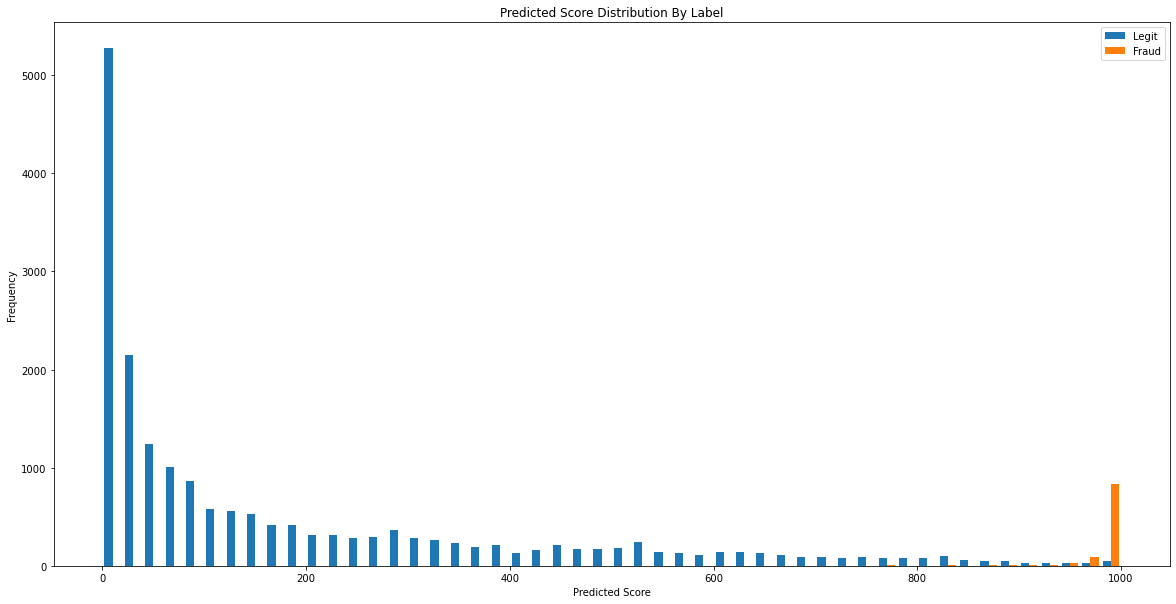

In [18]:
# -- check the distribution by Label --
plt.figure(figsize=(20,10))
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
plt.hist([df[df['EVENT_LABEL']=='legit']['score'], 
          df[df['EVENT_LABEL']=='fraud']['score']], bins = 50)
plt.legend(["Legit", "Fraud"])
plt.title("Predicted Score Distribution By Label")
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.text
plt.show()


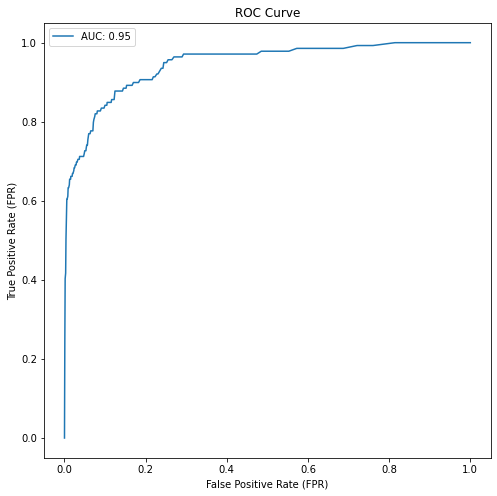

In [38]:

fig = plt.figure(figsize=(8,8))
plt.plot(df_model['fpr'],df_model['tpr'],label=f"AUC: {perf_auc:.2f}")
plt.title("ROC Curve")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (FPR)')
plt.legend()
plt.show()